In [6]:
1import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [8]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-05-12 23:33:58--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2020-05-12 23:33:58 (73.3 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



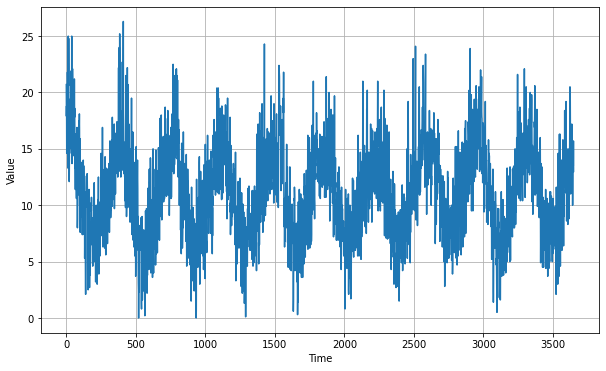

In [9]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader,n = csv.reader(csvfile, delimiter=','),0
  next(reader)
  for line in reader:
    time_step.append(n)
    n+=1
    temps.append(float(line[1]))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series=tf.expand_dims(series, -1)
    dataset=tf.data.Dataset.from_tensor_slices(series) # creates the dataset as np
    dataset=dataset.window(window_size+1, shift=1, drop_remainder=True) # splits array into segments of length window, moving by 1 value at a time
    dataset=dataset.flat_map(lambda w: w.batch(window_size+1)) # l
    dataset=dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[1:])) # separates the window into a long segment and then the last value
    return dataset.batch(batch_size).prefetch(1) # batches the windows together by batch size

'''
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
'''

In [24]:
def model_forecast(model, series, window_size):
    #same as above but no shuffle; we will instead use the model to predict the labels
    datas= tf.data.Dataset.from_tensor_slices(series)
    datas=datas.window(window_size, shift=1, drop_remainder=True)
    datas=datas.flat_map(lambda w: w.batch(window_size))
    datas=datas.batch(32).prefetch(1)
    forecast=model.predict(datas)
    return forecast

'''
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
'''

'\ndef model_forecast(model, series, window_size):\n    ds = tf.data.Dataset.from_tensor_slices(series)\n    ds = ds.window(window_size, shift=1, drop_remainder=True)\n    ds = ds.flat_map(lambda w: w.batch(window_size))\n    ds = ds.batch(32).prefetch(1)\n    forecast = model.predict(ds)\n    return forecast\n'

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(50, return_sequences=True),
  tf.keras.layers.LSTM(50, return_sequences=True),
  tf.keras.layers.LSTM(25),
  tf.keras.layers.Dense(25, activation="relu"),
  tf.keras.layers.Dense(25, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])



<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 22ms/step - loss: 2.6455 - mae: 3.1099 - lr: 1.0000e-06
Epoch 2/100
10/10 [==============================] - 0s 26ms/step - loss: 2.4766 - mae: 2.9382 - lr: 1.1220e-06
Epoch 3/100
10/10 [==============================] - 0s 26ms/step - loss: 2.3751 - mae: 2.8349 - lr: 1.2589e-06
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 2.3342 - mae: 2.7938 - lr: 1.4125e-06
Epoch 5/100
10/10 [==============================] - 0s 28ms/step - loss: 2.3117 - mae: 2.7713 - lr: 1.5849e-06
Epoch 6/100
10/10 [==============================] - 0s 27ms/step - loss: 2.3027 - mae: 2.7620 - lr: 1.7783e-06
Epoch 7/100
10/10 [==============================] - 0s 25ms/step - loss: 2.2649 - mae: 2.7237 - lr: 1.9953e-06
Epoch 8/100
10/10 [==============================] - 0s 25ms/step - loss: 2.2440 - mae: 2.7025 - lr: 2.2387e-06
Ep

(1e-06, 0.001, 1.0, 5.0)

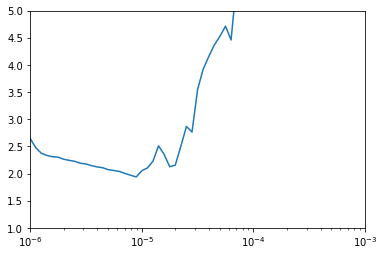

In [26]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 1, 5])

In [48]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=50, batch_size=125, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=50, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/50
20/20 [==============================] - 0s 14ms/step - loss: 3.1429 - mae: 3.6119
Epoch 2/50
20/20 [==============================] - 0s 16ms/step - loss: 2.0275 - mae: 2.4835
Epoch 3/50
20/20 [==============================] - 0s 16ms/step - loss: 1.8787 - mae: 2.3309
Epoch 4/50
20/20 [==============================] - 0s 18ms/step - loss: 1.8121 - mae: 2.2635
Epoch 5/50
20/20 [==============================] - 0s 15ms/step - loss: 1.7824 - mae: 2.2330
Epoch 6/50
20/20 [==============================] - 0s 15ms/step - loss: 1.7501 - mae: 2.2006
Epoch 7/50
20/20 [==============================] - 0s 17ms/step - loss: 1.7301 - mae: 2.1795
Epoch 8/50
20/20 [==============================] - 0s 16ms/step - loss: 1.7137 - mae: 2.1625
Epoch 9/50
20/20 [==============================] - 0s 16ms/step - loss: 1.7054 - mae: 2.1540
Epoch 10/50
20/20 [==============================] - 0s 17ms/step - loss: 1.6873 - mae: 2.1356
Epoch 11/50
20/20 [==============================] - 0s 17m

In [49]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print(rnn_forecast)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

[[[15.774928 ]
  [17.164583 ]
  [15.269606 ]
  ...
  [16.789726 ]
  [16.039064 ]
  [14.751395 ]]

 [[14.614598 ]
  [16.282402 ]
  [14.295838 ]
  ...
  [16.040955 ]
  [14.7519245]
  [15.115317 ]]

 [[15.014155 ]
  [15.393208 ]
  [13.716873 ]
  ...
  [14.74896  ]
  [15.112469 ]
  [13.6260805]]

 ...

 [[12.795466 ]
  [15.224692 ]
  [14.238806 ]
  ...
  [13.668018 ]
  [13.459924 ]
  [13.749676 ]]

 [[14.836067 ]
  [14.821037 ]
  [13.149267 ]
  ...
  [13.457314 ]
  [13.7472315]
  [14.882151 ]]

 [[12.282242 ]
  [13.860984 ]
  [13.953577 ]
  ...
  [13.745639 ]
  [14.881145 ]
  [13.677521 ]]]


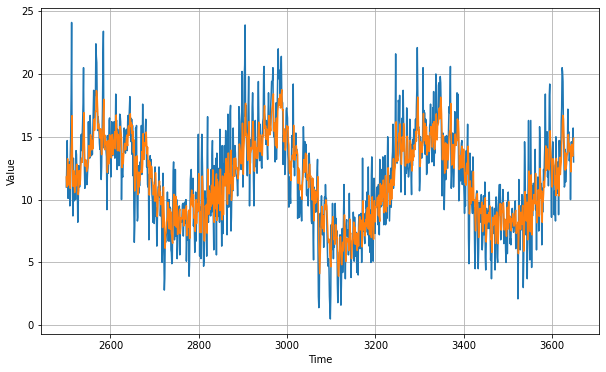

In [50]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [51]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7915368

In [52]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.79896  11.013441 11.945994 ... 13.460818 13.749676 14.882151]
